In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
import pickle

from joblib import dump

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://raw.githubusercontent.com/leilaff89/house_sales_prediction/main/datasets/house_prices_ml_features.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK,YEAR_SOLD
0,13.151488,12.807653,3,2,2.0,4.934474,2013,26900,8.496990,-32.193470,115.859554,1.709161,129.0,2019
1,12.571507,12.567237,3,1,1.0,4.454347,1979,22600,7.549609,-32.120578,115.993579,0.500277,113.0,2015
2,13.300859,13.437174,3,2,8.0,4.836282,1999,5900,6.230481,-31.917880,115.907050,-0.065880,29.0,2019
3,12.831836,12.814479,3,2,2.0,5.062595,2003,36300,7.649693,-31.654280,115.702200,-0.384423,39.0,2018
4,13.167607,13.190022,4,2,4.0,5.509388,2002,23100,8.268732,-32.159590,115.849480,0.797797,129.0,2019


In [5]:
X = df.drop(columns=['PRICE'],axis =1)
y = df['PRICE']

In [6]:
fs = SelectKBest(score_func=f_regression, k=3)
X_selected = fs.fit_transform(X, y)
X.columns[fs.get_support(indices=True)]

Index(['SUBURB', 'FLOOR_AREA', 'NEAREST_SCH_RANK'], dtype='object')

In [7]:
X = df.drop(columns=['PRICE'],axis =1).values 
y = df['PRICE'].values

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X) 

In [9]:
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [10]:
X[0:1]

array([[-0.42965461, -0.89997173,  0.23589087, -0.15445854, -0.61014886,
         1.09933878,  0.78468341,  0.60007618, -1.45556355, -0.04377577,
         2.08739396,  1.39948038,  0.68016718]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [12]:
print ('Train set size:', X_train.shape,  y_train.shape)
print ('Test set size:', X_test.shape,  y_test.shape)

Train set size: (15330, 13) (15330,)
Test set size: (3833, 13) (3833,)


In [13]:
level0 = list()
level0.append(('ann', MLPRegressor(activation = 'tanh', 
                                   hidden_layer_sizes = (100), 
                                   solver = 'lbfgs')))
level0.append(('svr', LinearSVR(random_state = 0, 
                                tol = 1e-5, 
                                C = 1.0, 
                                loss = 'squared_epsilon_insensitive')))
level0.append(('dt', DecisionTreeRegressor(criterion = 'friedman_mse', 
                                           max_depth = 10, 
                                           max_features = 'auto', 
                                           min_samples_leaf = 4, 
                                           min_samples_split = 10, 
                                           splitter = 'best')))
level0.append(('knn', KNeighborsRegressor(algorithm = 'auto', 
                                          n_neighbors = 7, 
                                          p = 1)))

In [14]:
level1 = LinearRegression()
#level1 = RandomForestRegressor(n_estimators=10, random_state=42)
#level1 = MLPRegressor(activation = 'tanh', 
                                   #hidden_layer_sizes = (100), 
                                   #solver = 'lbfgs')

In [15]:
stack = StackingRegressor(estimators=level0, final_estimator=level1, cv = 5)

In [16]:
stack.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('ann',
                               MLPRegressor(activation='tanh',
                                            hidden_layer_sizes=100,
                                            solver='lbfgs')),
                              ('svr',
                               LinearSVR(loss='squared_epsilon_insensitive',
                                         random_state=0, tol=1e-05)),
                              ('dt',
                               DecisionTreeRegressor(criterion='friedman_mse',
                                                     max_depth=10,
                                                     max_features='auto',
                                                     min_samples_leaf=4,
                                                     min_samples_split=10)),
                              ('knn', KNeighborsRegressor(n_neighbors=7, p=1))],
                  final_estimator=LinearRegression())

In [17]:
yhat_stk = stack.predict(X_test)

In [18]:
mse_stk = mean_squared_error(y_test, yhat_stk)
r2_stk = r2_score(y_test, yhat_stk)
print("Mean squared error: %.2f" % mse_stk)
print("Coefficient of determination: %.2f" % r2_stk)

Mean squared error: 0.04
Coefficient of determination: 0.85


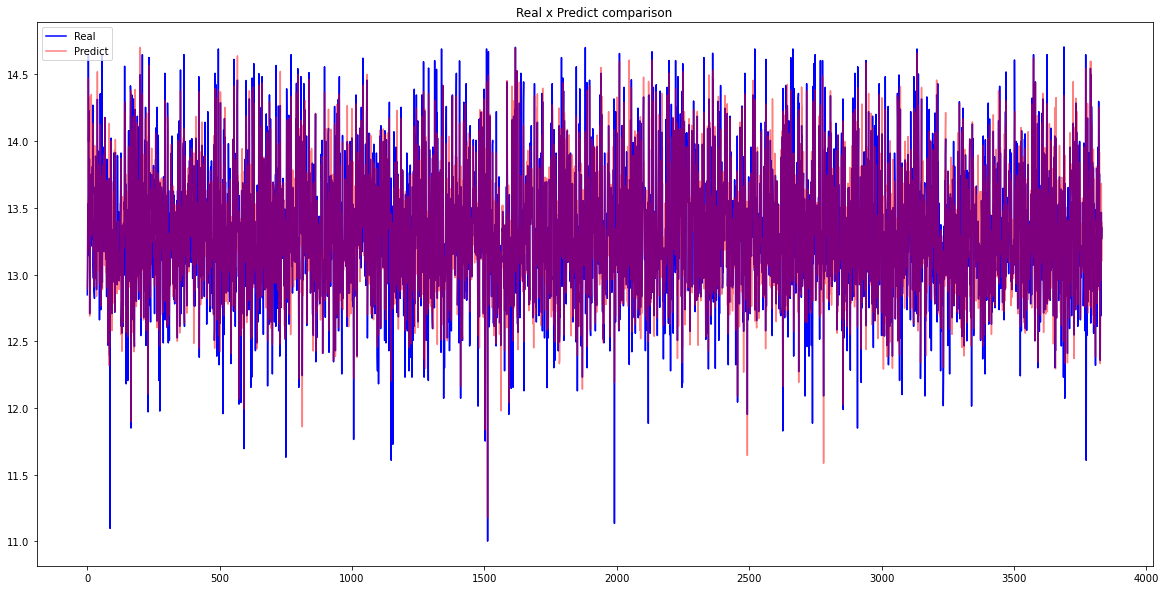

In [19]:
plt.figure(figsize=(20,10))
plt.plot(y_test, color='blue')
plt.plot(yhat_stk, color='red', alpha=0.5)

plt.legend(['Real', 'Predict'], loc='upper left')
plt.title('Real x Predict comparison')
plt.show()

In [20]:
pickle.dump(stack, open('stack.sav', 'wb'))
dump(stack, 'stack.pkl')

['stack.pkl']

In [21]:
!pip3 freeze > requirements.txt